In [2]:
import lineage_motif.resample as resample
import lineage_motif.plot as plot

In [3]:
dataset = 'rat_retina'

In [4]:
all_trees_sorted = resample.read_dataset(f'datasets/{dataset}.txt')

# print the first ten trees
all_trees_sorted[:10]

['((R,R),((A,B),((A,R),(B,M))))',
 '(R,((R,R),((R,R),((B,(R,R)),((B,M),(R,R))))))',
 '((A,R),((R,(M,R)),R))',
 '(R,(M,R))',
 '(R,(M,R))',
 '(B,(M,(R,R)))',
 '(R,(R,(R,(M,R))))',
 '(B,(B,M))',
 '(((R,(R,R)),M),R)',
 '(A,(M,R))']

We will first conduct doublet motif analysis by resampling the dataset `num_resamples` times with replacement. The following function `resample_trees_doublets` will automatically detect all cell fates in the dataset. It will output the  doublet dictionary, a list of the detected cell fates, and a DataFrame that lists the number of occurrences for each doublet in each resample and in the original dataset. The DataFrame will also contain the expected number of occurrences for each doublet based on the probabilities of observing each of its constituent cell fates.

## Doublet motif analysis

In [5]:
(doublet_dict, 
 cell_fates, 
 dfs_c) = resample.resample_trees_doublets(all_trees_sorted, 
                                           num_resamples=10000, 
                                           replacement_bool=True, 
                                           cell_fates='auto'
                                           )

  0%|          | 0/10000 [00:00<?, ?it/s]

In [6]:
doublet_dict

{'(A,A)': 0,
 '(A,B)': 1,
 '(A,M)': 2,
 '(A,R)': 3,
 '(B,B)': 4,
 '(B,M)': 5,
 '(B,R)': 6,
 '(M,M)': 7,
 '(M,R)': 8,
 '(R,R)': 9}

In [7]:
cell_fates

['A', 'B', 'M', 'R']

In [8]:
dfs_c.head()

,0,1,2,3,4,5,6,7,8,9,...,9992,9993,9994,9995,9996,9997,9998,9999,observed,expected
0,2.0,5.0,3.0,1,0.0,2.0,0.0,1.0,0.0,3.0,...,4.0,2.0,0.0,1.0,1.0,1.0,1.0,4.0,5.0,1.468910
1,3.0,0.0,4.0,2,5.0,3.0,5.0,4.0,3.0,2.0,...,3.0,4.0,1.0,6.0,2.0,7.0,7.0,4.0,12.0,3.655953
2,0.0,0.0,0.0,3,2.0,0.0,0.0,0.0,2.0,0.0,...,2.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.783419
3,20.0,22.0,23.0,24,27.0,22.0,18.0,25.0,14.0,26.0,...,20.0,24.0,19.0,19.0,19.0,26.0,17.0,27.0,15.0,21.609295
4,1.0,3.0,6.0,2,1.0,2.0,5.0,4.0,4.0,1.0,...,4.0,0.0,2.0,4.0,6.0,4.0,1.0,1.0,4.0,2.274815


We will now reformat the DataFrame for plotting. The next function `dfs_for_plotting` generates several DataFrames.

1. `df_true_melt_subset` will contain various characteristics about each of the doublets (i.e., the observed and expected number, z-score, adjusted p-value, etc.)

2. `df_melt_subset` will contain the number of occurences for each subtree in all of the resamples.

3. `df_melt_100resamples_subset` will contain the number of occurences for each subtree in only 100 resamples.

4. `df_null_zscores_i_c_melt_subset` will contain the null z-score for each subtree in `num_null` resamples. The null z-scores are calculated by comparison of each resample set to the rest of the resample sets.

5. `df_null_zscores_i_c_melt_100resamples_subset` will contain the null z-score for each subtree in 100 resamples.

We can also specify a cutoff number for how many subtrees we would like to include in the final plot. We can use `None` to keep all subtrees, `auto` to keep all subtrees with an absolute z-score above 1, or any number of top significant subtrees to keep (in order of highest to lowest absolute z-score).

In [11]:
# packages for both analysis and plotting
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import re

# packages for only plotting
import colorcet
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot
import matplotlib.patches as mpatches
from matplotlib.offsetbox import DrawingArea, AnnotationBbox
import matplotlib.font_manager as font_manager
from matplotlib.collections import PathCollection
from statsmodels.stats.multitest import multipletests
pyplot.rcParams['svg.fonttype'] = 'none'
mpl.rcParams.update({'font.size': 8})
mpl.rcParams['figure.dpi'] = 150

In [12]:
def dfs_for_plotting(dfs_c, num_resamples, subtree_dict, cutoff='auto', num_null=1000):
    """Converts DataFrame from resample_trees functions into DataFrames for plotting.
    
    Calculates z-scores by comparing the observed count in the original trees to the mean/std across all resamples.
    Calculates null z-scores by comparing the observed count of `num_null` random resamples to the mean/std across the rest of 
    the resamples.
    
    Args:
        dfs_c (DataFrame): Indexed by values from `subtree_dict`.
            Last column is analytically solved expected count of each subtree.
            Second to last column is observed count of occurences in the original dataset.
            Rest of columns are the observed count of occurences in the resampled sets.
            Output from resample_trees functions.
        num_resamples (int): Number of resamples.
        subtree_dict (dict): Keys are subtrees, values are integers.
        cutoff (string or NoneType or int, optional): Take `cutoff` number of subtrees with largest absolute z-scores 
            to include in plots.
            If not provided explicitly, will be automatically determined to take all subtrees with abs z-score > 1.
            If NoneType, take all subtrees.
        num_null (int, optional): Take `num_null` number of resamples to calculate z-scores as part of null distribution.

    Returns:
        (tuple): Contains the following DataFrames.
        
        - df_true_melt_subset (DataFrame): DataFrame indexed by `cutoff` number of most significant subtrees for plotting.
            Sorted by z-score from most over-represented to most under-represented. Contains the following columns: 
                - subtree_val (int): Value corresponding to `subtree_dict`.
                - observed (float): Count in original trees.
                - expected (float): Analytically solved expected count.
                - z-score (float): Computed using observed values and mean/std across resamples.
                - abs z-score (float): Absolute value of z-score.
                - label (string): Key corresponding to `subtree_dict`.
                - null min (float): Minimum count across across all resamples.
                - null mean (float): Average count across across all resamples.
                - null max (float): Maximum count across across all resamples.
                - p_val (float): p-value, one-sided test, not corrected for multiple hypotheses testing.
                - null z-score min (float): Minimum z-score across across `num_null` random resamples.
                - null z-score mean (float): Average z-score across across `num_null` random resamples.
                - null z-score max (float): Maximum z-score across across `num_null` random resamples.
        - df_melt_subset (DataFrame): Melted DataFrame with observed count for `cutoff` number of most significant subtrees 
            across all resamples. Contains the following columns:
                - subtree_val (int): Value corresponding to `subtree_dict`.
                - observed (int): Counts across all resamples.
                - label (string): Key corresponding to `subtree_dict`.
        - df_melt_100resamples_subset (DataFrame): Melted DataFrame with observed count for `cutoff` number of most significant
            subtrees across 100 random resamples. Contains the following columns:
                - subtree_val (int): Value corresponding to `subtree_dict`.
                - observed (int): Counts across 100 random resamples.
                - label (string): Key corresponding to `subtree_dict`.
        - df_null_zscores_i_c_melt_subset (DataFrame): Melted DataFrame with null z-score for `cutoff` number of most significant
            subtrees across `num_null` random resamples. Contains the following columns:
                - subtree_val (int): Value corresponding to `subtree_dict`.
                - observed (float): Z-scores across `num_null` random resamples.
                - label (string): Key corresponding to `subtree_dict`.
        - df_null_zscores_i_c_melt_100resamples_subset (DataFrame): Melted DataFrame with null z-score for `cutoff` number of 
            most significant subtrees across 100 random resamples. Contains the following columns:
                - subtree_val (int): Value corresponding to `subtree_dict`.
                - observed (float): Z-scores across 100 random resamples.
                - label (string): Key corresponding to `subtree_dict`.
    """

    # slice out the subtrees of the original trees
    df_true_slice = dfs_c.loc[:,'observed']

    # dataframe of original trees
    data = {'subtree_val': df_true_slice.index,
            'observed': df_true_slice.values}
    df_true_melt = pd.DataFrame(data)

    # slice out the subtrees of the original trees
    expected = dfs_c.loc[:,'expected'].values

    # dataframe of resampled trees
    resamples = num_resamples - 1
    df_melt = pd.melt(dfs_c.loc[:,'0':f'{resamples}'].transpose(), var_name='subtree_val', value_name='observed')
    df_melt_100resamples = pd.melt(dfs_c.loc[:,'0':'99'].transpose(), var_name='subtree_val', value_name='observed')

    # calculate zscores
    zscores = []
    for i in df_true_slice.index:
        actual = df_true_slice[i]
        mean = np.mean(df_melt.loc[df_melt['subtree_val']==i]['observed'].values)
        std = np.std(df_melt.loc[df_melt['subtree_val']==i]['observed'].values)
        if std == 0:
            zscore = 0
        else:
            zscore = (actual - mean) / std
        zscores.append(zscore)

    # assign to dataframe and subset based on subtrees with top 10 significance values
    df_true_melt['expected'] = expected
    df_true_melt['z-score'] = zscores
    df_true_melt['abs z-score'] = abs(df_true_melt['z-score'])
    df_true_melt.fillna(0, inplace=True)
    df_true_melt.sort_values('abs z-score', axis=0, ascending=False, inplace=True)
    
    # subset based on the number of subtrees
    if cutoff == 'auto':
        cutoff = (df_true_melt['abs z-score'].values>1).sum()
        df_true_melt_subset = df_true_melt.iloc[:cutoff].copy()
    elif cutoff == None:
        df_true_melt_subset = df_true_melt
    else:
        df_true_melt_subset = df_true_melt.iloc[:cutoff].copy()
    
    df_true_melt_subset.sort_values('z-score', axis=0, ascending=False, inplace=True)
    df_true_melt_subset['label'] = [list(subtree_dict.keys())[i] for i in df_true_melt_subset['subtree_val'].values]

    # subset the resamples
    df_melt_subset_list = []
    for i in df_true_melt_subset['subtree_val']:
        df_melt_subtree = df_melt.loc[df_melt['subtree_val']==i].copy()
        df_melt_subtree['label']=list(subtree_dict.keys())[i]
        df_melt_subset_list.append(df_melt_subtree)
    df_melt_subset = pd.concat(df_melt_subset_list)
    
    df_melt_100resamples_subset_list = []
    for i in df_true_melt_subset['subtree_val']:
        df_melt_100resamples_subtree = df_melt_100resamples.loc[df_melt_100resamples['subtree_val']==i].copy()
        df_melt_100resamples_subtree['label']=list(subtree_dict.keys())[i]
        df_melt_100resamples_subset_list.append(df_melt_100resamples_subtree)
    df_melt_100resamples_subset = pd.concat(df_melt_100resamples_subset_list)

    df_true_melt_subset['null min'] = [df_melt_subset.groupby(['subtree_val']).min(numeric_only=True).loc[i].values[0] for i in df_true_melt_subset['subtree_val']]
    df_true_melt_subset['null mean'] = [df_melt_subset.groupby(['subtree_val']).mean(numeric_only=True).loc[i].values[0] for i in df_true_melt_subset['subtree_val']]
    df_true_melt_subset['null max'] = [df_melt_subset.groupby(['subtree_val']).max(numeric_only=True).loc[i].values[0] for i in df_true_melt_subset['subtree_val']]
    
    # calculate p-value (one-sided test)
    p_val_list = []
    for i, j in zip(df_true_melt_subset['subtree_val'].values, df_true_melt_subset['z-score'].values):
        resamples = dfs_c.iloc[i].values[:-1]
        actual = df_true_melt_subset.loc[df_true_melt_subset['subtree_val']==i]['observed'].values[0]
        if j > 0:
            pos = sum(resamples>=actual)
        elif j < 0:
            pos = sum(resamples<=actual)
        elif j == 0:
            pos=len(resamples)

        p_val = pos/len(resamples)
        p_val_list.append(p_val)

    df_true_melt_subset['p_val'] = p_val_list
    
    # calculate deviation of each resample
    df_null_zscores_i_list = []
    for i in tqdm(range(num_null)):
        df_true_slice_i = dfs_c[f'{i}'].copy()
        data = {'subtree_val': df_true_slice_i.index,
                'observed': df_true_slice_i.values}
        df_true_melt_i = pd.DataFrame(data)

        df_subset_i = dfs_c[dfs_c.columns[~dfs_c.columns.isin([f'{i}','observed', 'expected'])]].copy()
        df_melt_i = pd.melt(df_subset_i.transpose(), var_name='subtree_val', value_name='observed')

        zscores_i = []
        for j in df_true_slice_i.index:
            actual = df_true_slice_i[j]
            mean = np.mean(df_melt_i.loc[df_melt_i['subtree_val']==j]['observed'].values)
            std = np.std(df_melt_i.loc[df_melt_i['subtree_val']==j]['observed'].values)
            if std == 0:
                zscore = 0
            else:
                zscore = (actual - mean) / std
            zscores_i.append(zscore)

        df_null_zscores_i = pd.DataFrame(zscores_i, columns=[i])
        df_null_zscores_i_list.append(df_null_zscores_i)
        
    df_null_zscores_i_c = pd.concat(df_null_zscores_i_list, axis=1)
    df_null_zscores_i_c.fillna(0, inplace=True)
    
    df_null_zscores_i_c_melt = df_null_zscores_i_c.transpose().melt(var_name='subtree_val', value_name='observed')
    df_null_zscores_i_c_melt_100resamples = df_null_zscores_i_c.loc[:,:99].transpose().melt(var_name='subtree_val', value_name='observed')
    
    # subset the resamples
    df_null_zscores_i_c_melt_subset_list = []
    for i in df_true_melt_subset['subtree_val']:
        df_null_zscores_i_c_melt_subtree = df_null_zscores_i_c_melt.loc[df_null_zscores_i_c_melt['subtree_val']==i].copy()
        df_null_zscores_i_c_melt_subtree['label']=list(subtree_dict.keys())[i]
        df_null_zscores_i_c_melt_subset_list.append(df_null_zscores_i_c_melt_subtree)
    df_null_zscores_i_c_melt_subset = pd.concat(df_null_zscores_i_c_melt_subset_list)
    
    # subset the resamples
    df_null_zscores_i_c_melt_100resamples_subset_list = []
    for i in df_true_melt_subset['subtree_val']:
        df_null_zscores_i_c_melt_100resamples_subtree = df_null_zscores_i_c_melt_100resamples.loc[df_null_zscores_i_c_melt_100resamples['subtree_val']==i].copy()
        df_null_zscores_i_c_melt_100resamples_subtree['label']=list(subtree_dict.keys())[i]
        df_null_zscores_i_c_melt_100resamples_subset_list.append(df_null_zscores_i_c_melt_100resamples_subtree)
    df_null_zscores_i_c_melt_100resamples_subset = pd.concat(df_null_zscores_i_c_melt_100resamples_subset_list)
    
    df_true_melt_subset['null z-score min'] = [df_null_zscores_i_c_melt_subset.groupby(['subtree_val']).min(numeric_only=True).loc[i].values[0] for i in df_true_melt_subset['subtree_val']]
    df_true_melt_subset['null z-score mean'] = [df_null_zscores_i_c_melt_subset.groupby(['subtree_val']).mean(numeric_only=True).loc[i].values[0] for i in df_true_melt_subset['subtree_val']]
    df_true_melt_subset['null z-score max'] = [df_null_zscores_i_c_melt_subset.groupby(['subtree_val']).max(numeric_only=True).loc[i].values[0] for i in df_true_melt_subset['subtree_val']]
    
    return (df_true_melt_subset, df_melt_subset, df_melt_100resamples_subset, df_null_zscores_i_c_melt_subset, df_null_zscores_i_c_melt_100resamples_subset)


In [13]:
(df_true_melt_subset, 
 df_melt_subset, 
 df_melt_100resamples_subset, 
 df_null_zscores_i_c_melt_subset, 
 df_null_zscores_i_c_melt_100resamples_subset) = dfs_for_plotting(dfs_c, 
                                                                       10000, 
                                                                       doublet_dict, 
                                                                       cutoff=None, 
                                                                       num_null=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [14]:
df_true_melt_subset.head()

,subtree_val,observed,expected,z-score,abs z-score,label,null min,null mean,null max,p_val,null z-score min,null z-score mean,null z-score max
1,1,12.0,3.655953,4.428774,4.428774,"(A,B)",0.0,3.6342,13.0,0.000600,-1.924363,0.000977,4.433345
5,5,4.0,0.974921,3.086136,3.086136,"(B,M)",0.0,0.9769,7.0,0.017098,-0.997369,0.066529,4.110661
0,0,5.0,1.468910,2.946122,2.946122,"(A,A)",0.0,1.4571,8.0,0.016298,-1.211811,-0.023329,5.449137
4,4,4.0,2.274815,1.159956,1.159956,"(B,B)",0.0,2.2668,10.0,0.191281,-1.517322,0.002171,3.840003
9,9,85.0,79.474185,0.930404,0.930404,"(R,R)",58.0,79.4275,101.0,0.196980,-3.580080,-0.025135,2.601047


In [15]:
pvals = df_true_melt_subset['p_val'].values
pvals

array([5.99940006e-04, 1.70982902e-02, 1.62983702e-02, 1.91280872e-01,
       1.96980302e-01, 5.16548345e-01, 9.02609739e-01, 4.61953805e-01,
       7.10928907e-02, 7.99920008e-04])

In [18]:
from statsmodels.stats.multitest import multipletests

In [19]:
methods = ['bonferroni',
'sidak',
'holm-sidak',
'holm',
'simes-hochberg',
'hommel',
'fdr_bh',
'fdr_by',
'fdr_tsbh',
'fdr_tsbky']

In [20]:
multipletests(pvals, method=methods[0])[1]

array([0.0059994 , 0.1709829 , 0.1629837 , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.71092891, 0.0079992 ])

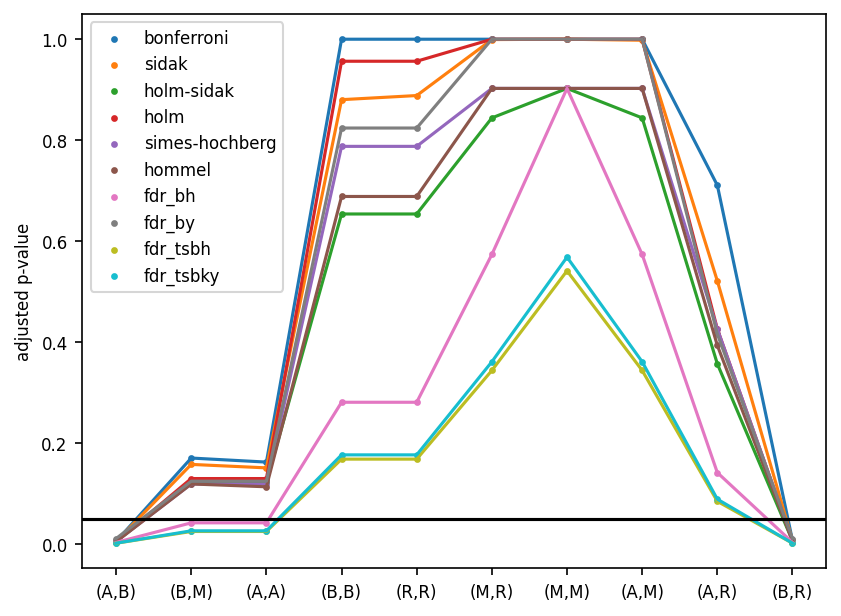

In [21]:
for method in methods:
    pyplot.scatter(x=df_true_melt_subset['label'], y=multipletests(pvals, method=method)[1], label=method, s=5)
    pyplot.plot(df_true_melt_subset['label'], multipletests(pvals, method=method)[1])

pyplot.axhline(0.05, color='black')
pyplot.ylabel('adjusted p-value')
pyplot.legend()

In [22]:
def dfs_for_plotting(dfs_c, num_resamples, subtree_dict, cutoff='auto', num_null=1000):
    """Converts DataFrame from resample_trees functions into DataFrames for plotting.
    
    Calculates z-scores by comparing the observed count in the original trees to the mean/std across all resamples.
    Calculates null z-scores by comparing the observed count of `num_null` random resamples to the mean/std across the rest of 
    the resamples.
    
    Args:
        dfs_c (DataFrame): Indexed by values from `subtree_dict`.
            Last column is analytically solved expected count of each subtree.
            Second to last column is observed count of occurences in the original dataset.
            Rest of columns are the observed count of occurences in the resampled sets.
            Output from resample_trees functions.
        num_resamples (int): Number of resamples.
        subtree_dict (dict): Keys are subtrees, values are integers.
        cutoff (string or NoneType or int, optional): Take `cutoff` number of subtrees with largest absolute z-scores 
            to include in plots.
            If not provided explicitly, will be automatically determined to take all subtrees with abs z-score > 1.
            If NoneType, take all subtrees.
        num_null (int, optional): Take `num_null` number of resamples to calculate z-scores as part of null distribution.

    Returns:
        (tuple): Contains the following DataFrames.
        
        - df_true_melt_subset (DataFrame): DataFrame indexed by `cutoff` number of most significant subtrees for plotting.
            Sorted by z-score from most over-represented to most under-represented. Contains the following columns: 
                - subtree_val (int): Value corresponding to `subtree_dict`.
                - observed (float): Count in original trees.
                - expected (float): Analytically solved expected count.
                - z-score (float): Computed using observed values and mean/std across resamples.
                - abs z-score (float): Absolute value of z-score.
                - label (string): Key corresponding to `subtree_dict`.
                - null min (float): Minimum count across across all resamples.
                - null mean (float): Average count across across all resamples.
                - null max (float): Maximum count across across all resamples.
                - p_val (float): p-value, one-sided test, not corrected for multiple hypotheses testing.
                - null z-score min (float): Minimum z-score across across `num_null` random resamples.
                - null z-score mean (float): Average z-score across across `num_null` random resamples.
                - null z-score max (float): Maximum z-score across across `num_null` random resamples.
        - df_melt_subset (DataFrame): Melted DataFrame with observed count for `cutoff` number of most significant subtrees 
            across all resamples. Contains the following columns:
                - subtree_val (int): Value corresponding to `subtree_dict`.
                - observed (int): Counts across all resamples.
                - label (string): Key corresponding to `subtree_dict`.
        - df_melt_100resamples_subset (DataFrame): Melted DataFrame with observed count for `cutoff` number of most significant
            subtrees across 100 random resamples. Contains the following columns:
                - subtree_val (int): Value corresponding to `subtree_dict`.
                - observed (int): Counts across 100 random resamples.
                - label (string): Key corresponding to `subtree_dict`.
        - df_null_zscores_i_c_melt_subset (DataFrame): Melted DataFrame with null z-score for `cutoff` number of most significant
            subtrees across `num_null` random resamples. Contains the following columns:
                - subtree_val (int): Value corresponding to `subtree_dict`.
                - observed (float): Z-scores across `num_null` random resamples.
                - label (string): Key corresponding to `subtree_dict`.
        - df_null_zscores_i_c_melt_100resamples_subset (DataFrame): Melted DataFrame with null z-score for `cutoff` number of 
            most significant subtrees across 100 random resamples. Contains the following columns:
                - subtree_val (int): Value corresponding to `subtree_dict`.
                - observed (float): Z-scores across 100 random resamples.
                - label (string): Key corresponding to `subtree_dict`.
    """

    # slice out the subtrees of the original trees
    df_true_slice = dfs_c.loc[:,'observed']

    # dataframe of original trees
    data = {'subtree_val': df_true_slice.index,
            'observed': df_true_slice.values}
    df_true_melt = pd.DataFrame(data)

    # slice out the subtrees of the original trees
    expected = dfs_c.loc[:,'expected'].values

    # dataframe of resampled trees
    resamples = num_resamples - 1
    df_melt = pd.melt(dfs_c.loc[:,'0':f'{resamples}'].transpose(), var_name='subtree_val', value_name='observed')
    df_melt_100resamples = pd.melt(dfs_c.loc[:,'0':'99'].transpose(), var_name='subtree_val', value_name='observed')

    # calculate zscores
    zscores = []
    for i in df_true_slice.index:
        actual = df_true_slice[i]
        mean = np.mean(df_melt.loc[df_melt['subtree_val']==i]['observed'].values)
        std = np.std(df_melt.loc[df_melt['subtree_val']==i]['observed'].values)
        if std == 0:
            zscore = 0
        else:
            zscore = (actual - mean) / std
        zscores.append(zscore)

    # assign to dataframe and subset based on subtrees with top 10 significance values
    df_true_melt['expected'] = expected
    df_true_melt['z-score'] = zscores
    df_true_melt['abs z-score'] = abs(df_true_melt['z-score'])
    df_true_melt.fillna(0, inplace=True)
    df_true_melt.sort_values('abs z-score', axis=0, ascending=False, inplace=True)
    
    # subset based on the number of subtrees
    if cutoff == 'auto':
        cutoff = (df_true_melt['abs z-score'].values>1).sum()
        df_true_melt_subset = df_true_melt.iloc[:cutoff].copy()
    elif cutoff == None:
        df_true_melt_subset = df_true_melt
    else:
        df_true_melt_subset = df_true_melt.iloc[:cutoff].copy()
    
    df_true_melt_subset.sort_values('z-score', axis=0, ascending=False, inplace=True)
    df_true_melt_subset['label'] = [list(subtree_dict.keys())[i] for i in df_true_melt_subset['subtree_val'].values]

    # subset the resamples
    df_melt_subset_list = []
    for i in df_true_melt_subset['subtree_val']:
        df_melt_subtree = df_melt.loc[df_melt['subtree_val']==i].copy()
        df_melt_subtree['label']=list(subtree_dict.keys())[i]
        df_melt_subset_list.append(df_melt_subtree)
    df_melt_subset = pd.concat(df_melt_subset_list)
    
    df_melt_100resamples_subset_list = []
    for i in df_true_melt_subset['subtree_val']:
        df_melt_100resamples_subtree = df_melt_100resamples.loc[df_melt_100resamples['subtree_val']==i].copy()
        df_melt_100resamples_subtree['label']=list(subtree_dict.keys())[i]
        df_melt_100resamples_subset_list.append(df_melt_100resamples_subtree)
    df_melt_100resamples_subset = pd.concat(df_melt_100resamples_subset_list)

    df_true_melt_subset['null min'] = [df_melt_subset.groupby(['subtree_val']).min(numeric_only=True).loc[i].values[0] for i in df_true_melt_subset['subtree_val']]
    df_true_melt_subset['null mean'] = [df_melt_subset.groupby(['subtree_val']).mean(numeric_only=True).loc[i].values[0] for i in df_true_melt_subset['subtree_val']]
    df_true_melt_subset['null max'] = [df_melt_subset.groupby(['subtree_val']).max(numeric_only=True).loc[i].values[0] for i in df_true_melt_subset['subtree_val']]
    
    # calculate p-value (one-sided test)
    p_val_list = []
    for i, j in zip(df_true_melt_subset['subtree_val'].values, df_true_melt_subset['z-score'].values):
        resamples = dfs_c.iloc[i].values[:-1]
        actual = df_true_melt_subset.loc[df_true_melt_subset['subtree_val']==i]['observed'].values[0]
        if j > 0:
            pos = sum(resamples>=actual)
        elif j < 0:
            pos = sum(resamples<=actual)
        elif j == 0:
            pos=len(resamples)

        p_val = pos/len(resamples)
        p_val_list.append(p_val)

    df_true_melt_subset['p_val'] = p_val_list
    df_true_melt_subset['adj_p_val_fdr_bh'] = multipletests(p_val_list, method='fdr_bh')[1]
    df_true_melt_subset['adj_p_val_fdr_tsbh'] = multipletests(p_val_list, method='fdr_tsbh')[1]
    
    # calculate deviation of each resample
    df_null_zscores_i_list = []
    for i in tqdm(range(num_null)):
        df_true_slice_i = dfs_c[f'{i}'].copy()
        data = {'subtree_val': df_true_slice_i.index,
                'observed': df_true_slice_i.values}
        df_true_melt_i = pd.DataFrame(data)

        df_subset_i = dfs_c[dfs_c.columns[~dfs_c.columns.isin([f'{i}','observed', 'expected'])]].copy()
        df_melt_i = pd.melt(df_subset_i.transpose(), var_name='subtree_val', value_name='observed')

        zscores_i = []
        for j in df_true_slice_i.index:
            actual = df_true_slice_i[j]
            mean = np.mean(df_melt_i.loc[df_melt_i['subtree_val']==j]['observed'].values)
            std = np.std(df_melt_i.loc[df_melt_i['subtree_val']==j]['observed'].values)
            if std == 0:
                zscore = 0
            else:
                zscore = (actual - mean) / std
            zscores_i.append(zscore)

        df_null_zscores_i = pd.DataFrame(zscores_i, columns=[i])
        df_null_zscores_i_list.append(df_null_zscores_i)
        
    df_null_zscores_i_c = pd.concat(df_null_zscores_i_list, axis=1)
    df_null_zscores_i_c.fillna(0, inplace=True)
    
    df_null_zscores_i_c_melt = df_null_zscores_i_c.transpose().melt(var_name='subtree_val', value_name='observed')
    df_null_zscores_i_c_melt_100resamples = df_null_zscores_i_c.loc[:,:99].transpose().melt(var_name='subtree_val', value_name='observed')
    
    # subset the resamples
    df_null_zscores_i_c_melt_subset_list = []
    for i in df_true_melt_subset['subtree_val']:
        df_null_zscores_i_c_melt_subtree = df_null_zscores_i_c_melt.loc[df_null_zscores_i_c_melt['subtree_val']==i].copy()
        df_null_zscores_i_c_melt_subtree['label']=list(subtree_dict.keys())[i]
        df_null_zscores_i_c_melt_subset_list.append(df_null_zscores_i_c_melt_subtree)
    df_null_zscores_i_c_melt_subset = pd.concat(df_null_zscores_i_c_melt_subset_list)
    
    # subset the resamples
    df_null_zscores_i_c_melt_100resamples_subset_list = []
    for i in df_true_melt_subset['subtree_val']:
        df_null_zscores_i_c_melt_100resamples_subtree = df_null_zscores_i_c_melt_100resamples.loc[df_null_zscores_i_c_melt_100resamples['subtree_val']==i].copy()
        df_null_zscores_i_c_melt_100resamples_subtree['label']=list(subtree_dict.keys())[i]
        df_null_zscores_i_c_melt_100resamples_subset_list.append(df_null_zscores_i_c_melt_100resamples_subtree)
    df_null_zscores_i_c_melt_100resamples_subset = pd.concat(df_null_zscores_i_c_melt_100resamples_subset_list)
    
    df_true_melt_subset['null z-score min'] = [df_null_zscores_i_c_melt_subset.groupby(['subtree_val']).min(numeric_only=True).loc[i].values[0] for i in df_true_melt_subset['subtree_val']]
    df_true_melt_subset['null z-score mean'] = [df_null_zscores_i_c_melt_subset.groupby(['subtree_val']).mean(numeric_only=True).loc[i].values[0] for i in df_true_melt_subset['subtree_val']]
    df_true_melt_subset['null z-score max'] = [df_null_zscores_i_c_melt_subset.groupby(['subtree_val']).max(numeric_only=True).loc[i].values[0] for i in df_true_melt_subset['subtree_val']]
    
    return (df_true_melt_subset, df_melt_subset, df_melt_100resamples_subset, df_null_zscores_i_c_melt_subset, df_null_zscores_i_c_melt_100resamples_subset)


In [23]:
(df_true_melt_subset, 
 df_melt_subset, 
 df_melt_100resamples_subset, 
 df_null_zscores_i_c_melt_subset, 
 df_null_zscores_i_c_melt_100resamples_subset) = dfs_for_plotting(dfs_c, 
                                                                       10000, 
                                                                       doublet_dict, 
                                                                       cutoff=None, 
                                                                       num_null=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [25]:
df_true_melt_subset

,subtree_val,observed,expected,z-score,abs z-score,label,null min,null mean,null max,p_val,adj_p_val_fdr_bh,adj_p_val_fdr_tsbh,null z-score min,null z-score mean,null z-score max
1,1,12.0,3.655953,4.428774,4.428774,"(A,B)",0.0,3.6342,13.0,0.000600,0.004000,0.002400,-1.924363,0.000977,4.433345
5,5,4.0,0.974921,3.086136,3.086136,"(B,M)",0.0,0.9769,7.0,0.017098,0.042746,0.025647,-0.997369,0.066529,4.110661
0,0,5.0,1.468910,2.946122,2.946122,"(A,A)",0.0,1.4571,8.0,0.016298,0.042746,0.025647,-1.211811,-0.023329,5.449137
4,4,4.0,2.274815,1.159956,1.159956,"(B,B)",0.0,2.2668,10.0,0.191281,0.281400,0.168840,-1.517322,0.002171,3.840003
9,9,85.0,79.474185,0.930404,0.930404,"(R,R)",58.0,79.4275,101.0,0.196980,0.281400,0.168840,-3.580080,-0.025135,2.601047
8,8,6.0,5.762479,0.102777,0.102777,"(M,R)",0.0,5.7591,16.0,0.516548,0.573943,0.344366,-2.457924,-0.010689,3.945797
7,7,0.0,0.104456,-0.318255,0.318255,"(M,M)",0.0,0.1032,3.0,0.902610,0.902610,0.541566,-0.318273,-0.031296,8.969663
2,2,0.0,0.783419,-0.882257,0.882257,"(A,M)",0.0,0.7692,6.0,0.461954,0.573943,0.344366,-0.882335,0.058330,3.708394
3,3,15.0,21.609295,-1.549266,1.549266,"(A,R)",8.0,21.6789,39.0,0.071093,0.142186,0.085311,-2.478008,0.016273,3.556373
6,6,12.0,26.891567,-3.162096,3.162096,"(B,R)",7.0,26.9271,48.0,0.000800,0.004000,0.002400,-3.163837,0.004856,3.831491


In [26]:
df_melt_subset.head()

,subtree_val,observed,label
10000,1,3.0,"(A,B)"
10001,1,0.0,"(A,B)"
10002,1,4.0,"(A,B)"
10003,1,2.0,"(A,B)"
10004,1,5.0,"(A,B)"


In [27]:
df_melt_100resamples_subset.head()

,subtree_val,observed,label
100,1,3.0,"(A,B)"
101,1,0.0,"(A,B)"
102,1,4.0,"(A,B)"
103,1,2.0,"(A,B)"
104,1,5.0,"(A,B)"


In [28]:
df_null_zscores_i_c_melt_subset.head()

,subtree_val,observed,label
1000,1,-0.335758,"(A,B)"
1001,1,-1.924363,"(A,B)"
1002,1,0.193661,"(A,B)"
1003,1,-0.865205,"(A,B)"
1004,1,0.723096,"(A,B)"


In [29]:
df_null_zscores_i_c_melt_100resamples_subset.head()

,subtree_val,observed,label
100,1,-0.335758,"(A,B)"
101,1,-1.924363,"(A,B)"
102,1,0.193661,"(A,B)"
103,1,-0.865205,"(A,B)"
104,1,0.723096,"(A,B)"


We will specify a dictionary of cell fates with assigned colors for plotting purposes.

In [30]:
cell_fates

['A', 'B', 'M', 'R']

In [31]:
cell_color_dict = plot.make_color_dict(cell_fates, ['#F89A3A', 
                                                    '#9C80B8', 
                                                    '#F071AB', 
                                                    '#7EC352', 
                                                   ])

Lastly, we will plot the frequency and deviation plot using the DataFrame outputs from `dfs_for_plotting` and cell color dictionary.

In [32]:
def _annot(number):
    if number < 0.0005:
        return '***'
    elif number < 0.005:
        return '**'
    elif number < 0.05:
        return '*'

In [33]:
def plot_frequency(subtree, 
                   df_true_melt_subset, 
                   df_melt_subset, 
                   df_melt_100resamples_subset, 
                   cell_color_dict,
                   fdr_type='fdr_tsbh',
                   cutoff='auto', 
                   title='auto',
                   multiple_datasets=False,
                   legend_bool=True, 
                   legend_pos='outside',
                   save=False, 
                   image_format='png',
                   dpi=300,
                   image_save_path=None):
    
    """Plots frequency of `cutoff` number of subtrees in original dataset and all resamples.
    
    Args:
        subtree (string): Type of subtree.
        df_true_melt_subset (DataFrame): DataFrame with `cutoff` number of most significant subtrees for plotting.
            Sorted by z-score from most over-represented to most under-represented.
            Output from `dfs_for_plotting` function.
        df_melt_subset (DataFrame): Melted DataFrame with observed count for `cutoff` number of most significant subtrees 
            across all resamples.
            Output from `dfs_for_plotting` function.
        df_melt_100resamples_subset (DataFrame): Melted DataFrame with observed count for `cutoff` number of most significant
            subtrees across 100 random resamples.
            Output from `dfs_for_plotting` function.
        cell_color_dict (dict): Keys are cell fates, values are colors.
        fdr_type (string, optional): Use the Benjamini and Hochberg FDR correction if 'fdr_bh', use Benjamini and Hochberg FDR correction
            with two stage linear step-up procedure if 'fdr_tsbh'. Uses 'fdr_tsbh' by default.
        cutoff (string or NoneType or int, optional): Take `cutoff` number of subtrees with largest absolute z-scores 
            to include in plots.
            If not provided explicitly, will be automatically determined to take all subtrees with abs z-score > 1.
            If NoneType, take all subtrees.
        title (string, optional): Title to use for plot. If not provided explicitly, will be automatically determined to read `subtree` frequency.
        multiple_datasets (bool, optional): Modify x-axis label depending if single or multiple datasets were used.
        legend_bool (bool, optional): Include legend in plot.
        legend_pos (string, optional): Position of legend (outside or inside).
        save (bool, optional): If True, save figure as file.
        image format (string, optional): Format of image file to be saved (png or svg).
        dpi (int, optional): Resolution of saved image file.
        image_save_path (string, optional): Path to saved image file.
    """

    df_true_melt_subset_sg = df_true_melt_subset.loc[df_true_melt_subset[f'adj_p_val_{fdr_type}']<0.05].copy()
    
    margins=0.05
    bbox_to_anchor=(0, 0)  
    figsize=(0.23*len(df_true_melt_subset)+margins, 2.5)

    sns.set_style('whitegrid')
    fig, ax = pyplot.subplots(figsize=figsize)
    pyplot.setp(ax.collections)

    sns.violinplot(x='label', 
                   y='observed', 
                   data=df_melt_subset, 
                   cut=0,
                   inner=None,
                   color='#BCBEC0',
                   scale='width',
                   linewidth=0,
                   )
    sns.stripplot(x='label', 
                  y='observed', 
                  data=df_melt_100resamples_subset, 
                  jitter=0.2,
                  color='gray',
                  size=0.5,
                 )
    pyplot.scatter(x='label', y='observed', data=df_true_melt_subset, color='red', label='Observed count', s=2.5)
    pyplot.scatter(x='label', y='null mean', data=df_true_melt_subset, color='gray', label='Count across all resamples', s=2.5)
    pyplot.scatter(x='label', y='expected', data=df_true_melt_subset, color='black', label='Expected count', s=2.5)
    pyplot.scatter(x='label', y='null min', data=df_true_melt_subset, color='gray', s=0, label='')
    pyplot.scatter(x='label', y='null max', data=df_true_melt_subset, color='gray', s=0, label='')
    pyplot.scatter(x='label', y='observed', data=df_true_melt_subset, color='red', label='', s=2.5)
    pyplot.scatter(x='label', y='observed', data=df_true_melt_subset_sg, color='red', s=25, alpha=0.35, label='Adjusted p-value < 0.05')

    # add annotations for adjusted p-value
    for label in df_true_melt_subset_sg['label'].values:
        adj_p_val = df_true_melt_subset_sg.loc[df_true_melt_subset_sg['label']==label][f'adj_p_val_{fdr_type}'].values[0]
        val = df_true_melt_subset_sg.loc[df_true_melt_subset_sg['label']==label]['observed'].values[0]
        null = df_true_melt_subset_sg.loc[df_true_melt_subset_sg['label']==label]['null mean'].values[0]
        if val > null:
            y_coord = val+max(df_true_melt_subset['observed'])/10
            pyplot.annotate(_annot(adj_p_val), xy=(label, y_coord), ha='center', va='bottom')
        else:
            y_coord = val-max(df_true_melt_subset['observed'])/10
            pyplot.annotate(_annot(adj_p_val), xy=(label, y_coord), ha='center', va='top')

    pyplot.margins(margins)
    pyplot.grid(True)
    ax.set_xticklabels([])

    if title == 'auto':
        pyplot.title(f'{subtree.capitalize()} frequency', y=1.02, **{'fontname':'Arial', 'size':8}, fontweight='bold')
    else:
        pyplot.title(f'{title}', y=1.02, **{'fontname':'Arial', 'size':8}, fontweight='bold')
    pyplot.ylabel('Counts', **{'fontname':'Arial', 'size':8})
    pyplot.yticks(**{'fontname':'Arial', 'size':8})

    if legend_bool == True:
        legend_props = font_manager.FontProperties(family='Arial', style='normal', size=6)
        if legend_pos == 'outside':
            pyplot.legend(loc='upper left', framealpha=1, prop=legend_props, bbox_to_anchor=(1.05,1.0))
        elif legend_pos == 'inside':
            pyplot.legend(loc='upper right', framealpha=1, prop=legend_props)

    for i, artist in enumerate(ax.findobj(PathCollection)):
        artist.set_zorder(1)

    if subtree == 'doublet':   
        for i in range(len(df_true_melt_subset['label'].values)):
            c1_str = df_true_melt_subset['label'].values[i][1]
            c2_str = df_true_melt_subset['label'].values[i][3]

            x = i
            y = -0.06
            ax.add_artist(_make_circle(cell_color_dict[c1_str], 4.5, x, y, 0.4))
            ax.annotate(c1_str, 
                        xy=(x, y), 
                        verticalalignment="center", 
                        horizontalalignment="center",
                        annotation_clip=False, 
                        xycoords=("data", "axes fraction"),
                        **{'fontname':'Arial', 'size':8})

            x = i
            y = -0.15
            ax.add_artist(_make_circle(cell_color_dict[c2_str], 4.5, x, y, 0.4))
            ax.annotate(c2_str, 
                        xy=(x, y), 
                        verticalalignment="center", 
                        horizontalalignment="center",
                        annotation_clip=False, 
                        xycoords=("data", "axes fraction"),
                        **{'fontname':'Arial', 'size':8})  
        if cutoff==None:
            pyplot.xlabel(f'All {subtree} combinations', labelpad=22.5, **{'fontname':'Arial', 'size':8})
        else:
            if multiple_datasets == False:
                pyplot.xlabel(f'{subtree.capitalize()} combinations \n(top {len(df_true_melt_subset)} by abs z-score)', labelpad=22.5, **{'fontname':'Arial', 'size':8})
            else:
                pyplot.xlabel(f'{subtree.capitalize()} combinations \n(top {len(df_true_melt_subset)} by abs z-score across all datasets)', labelpad=22.5, **{'fontname':'Arial', 'size':8})
    
    if subtree == 'triplet':
        for i in range(len(df_true_melt_subset['label'].values)):
            c1_str = df_true_melt_subset['label'].values[i][1]
            c2_str = df_true_melt_subset['label'].values[i][4]
            c3_str = df_true_melt_subset['label'].values[i][6]

            x = i
            y = -0.06
            ax.add_artist(_make_circle(cell_color_dict[c1_str], 4.5, x, y, 0.4))
            ax.annotate(c1_str, 
                        xy=(x, y), 
                        verticalalignment='center', 
                        horizontalalignment='center',
                        annotation_clip=False, 
                        xycoords=('data', 'axes fraction'),
                        **{'fontname':'Arial', 'size':8})

            x = i
            y = -0.18
            ax.add_artist(_make_circle(cell_color_dict[c2_str], 4.5, x, y, 0.4))
            ax.annotate(c2_str, 
                        xy=(x, y), 
                        verticalalignment='center', 
                        horizontalalignment='center',
                        annotation_clip=False, 
                        xycoords=('data', 'axes fraction'),
                        **{'fontname':'Arial', 'size':8})   

            x = i
            y = -0.27
            ax.add_artist(_make_circle(cell_color_dict[c3_str], 4.5, x, y, 0.4))
            ax.annotate(c3_str, 
                        xy=(x, y), 
                        verticalalignment='center', 
                        horizontalalignment='center',
                        annotation_clip=False, 
                        xycoords=('data', 'axes fraction'),
                        **{'fontname':'Arial', 'size':8}) 
            
        if cutoff==None:
            pyplot.xlabel(f'All {subtree} combinations', labelpad=40, **{'fontname':'Arial', 'size':8})
        else:
            if multiple_datasets == False:
                pyplot.xlabel(f'{subtree.capitalize()} combinations \n(top {len(df_true_melt_subset)} by abs z-score)', labelpad=40, **{'fontname':'Arial', 'size':8})
            else:
                pyplot.xlabel(f'{subtree.capitalize()} combinations \n(top {len(df_true_melt_subset)} by abs z-score across all datasets)', labelpad=40, **{'fontname':'Arial', 'size':8})
    

    if subtree == 'quartet':
        for i in range(len(df_true_melt_subset['label'].values)):
            c1_str = df_true_melt_subset['label'].values[i][2]
            c2_str = df_true_melt_subset['label'].values[i][4]
            c3_str = df_true_melt_subset['label'].values[i][8]
            c4_str = df_true_melt_subset['label'].values[i][10]

            x = i
            y = -0.06
            ax.add_artist(_make_circle(cell_color_dict[c1_str], 4.5, x, y, 0.4))
            ax.annotate(c1_str, 
                        xy=(x, y), 
                        verticalalignment="center", 
                        horizontalalignment="center",
                        annotation_clip=False, 
                        xycoords=("data", "axes fraction"),
                        **{'fontname':'Arial', 'size':8})

            x = i
            y = -0.15
            ax.add_artist(_make_circle(cell_color_dict[c2_str], 4.5, x, y, 0.4))
            ax.annotate(c2_str, 
                        xy=(x, y), 
                        verticalalignment="center", 
                        horizontalalignment="center",
                        annotation_clip=False, 
                        xycoords=("data", "axes fraction"),
                        **{'fontname':'Arial', 'size':8})   

            x = i
            y = -0.27
            ax.add_artist(_make_circle(cell_color_dict[c3_str], 4.5, x, y, 0.4))
            ax.annotate(c3_str, 
                        xy=(x, y), 
                        verticalalignment="center", 
                        horizontalalignment="center",
                        annotation_clip=False, 
                        xycoords=("data", "axes fraction"),
                        **{'fontname':'Arial', 'size':8})  

            x = i
            y = -0.36
            ax.add_artist(_make_circle(cell_color_dict[c4_str], 4.5, x, y, 0.4))
            ax.annotate(c4_str, 
                        xy=(x, y), 
                        verticalalignment="center", 
                        horizontalalignment="center",
                        annotation_clip=False, 
                        xycoords=("data", "axes fraction"),
                        **{'fontname':'Arial', 'size':8})  
            
        if cutoff==None:
            pyplot.xlabel(f'All {subtree} combinations', labelpad=52.5, **{'fontname':'Arial', 'size':8})
        else:
            if multiple_datasets == False:
                pyplot.xlabel(f'{subtree.capitalize()} combinations \n(top {len(df_true_melt_subset)} by abs z-score)', labelpad=52.5, **{'fontname':'Arial', 'size':8})
            else:
                pyplot.xlabel(f'{subtree.capitalize()} combinations \n(top {len(df_true_melt_subset)} by abs z-score across all datasets)', labelpad=52.5, **{'fontname':'Arial', 'size':8})
            
    if save==True:
        pyplot.savefig(f"{image_save_path}.{image_format}", dpi=dpi, bbox_inches="tight")

In [34]:
def _make_circle(color, size, x, y, alpha):
    da = DrawingArea(0, 0, 0, 0)
    p = mpatches.Circle((0, 0), size, color=color, alpha=alpha)
    da.add_artist(p)

    c1 = AnnotationBbox(da, 
                        (x,y),
                        xybox=(0, 0),
                        frameon=False,
                        xycoords=("data", "axes fraction"),
                        box_alignment=(0.5, 0.5),
                        boxcoords="offset points",
                        bboxprops={"edgecolor" : "none"},
                        pad=0)
    return c1

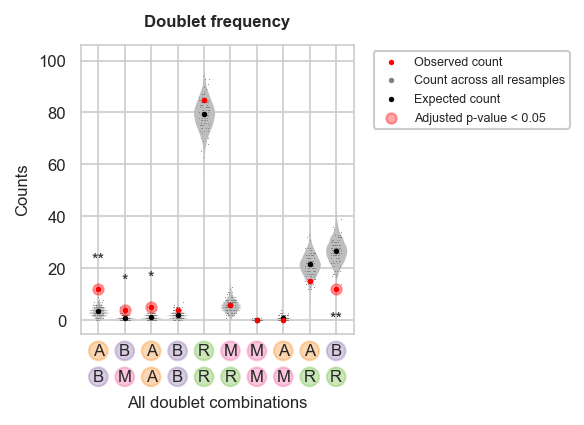

In [35]:
plot_frequency('doublet', 
                    df_true_melt_subset, 
                    df_melt_subset, 
                    df_melt_100resamples_subset, 
                    cell_color_dict,
                    fdr_type='fdr_tsbh',
                    cutoff=None, 
                    title='auto',
                    multiple_datasets=False,
                    legend_bool=True, 
                    legend_pos='outside',
                    save=False, 
                    image_format='png',
                    dpi=300,
                    image_save_path=None)

In [36]:
df_true_melt_subset.head()

,subtree_val,observed,expected,z-score,abs z-score,label,null min,null mean,null max,p_val,adj_p_val_fdr_bh,adj_p_val_fdr_tsbh,null z-score min,null z-score mean,null z-score max
1,1,12.0,3.655953,4.428774,4.428774,"(A,B)",0.0,3.6342,13.0,0.000600,0.004000,0.002400,-1.924363,0.000977,4.433345
5,5,4.0,0.974921,3.086136,3.086136,"(B,M)",0.0,0.9769,7.0,0.017098,0.042746,0.025647,-0.997369,0.066529,4.110661
0,0,5.0,1.468910,2.946122,2.946122,"(A,A)",0.0,1.4571,8.0,0.016298,0.042746,0.025647,-1.211811,-0.023329,5.449137
4,4,4.0,2.274815,1.159956,1.159956,"(B,B)",0.0,2.2668,10.0,0.191281,0.281400,0.168840,-1.517322,0.002171,3.840003
9,9,85.0,79.474185,0.930404,0.930404,"(R,R)",58.0,79.4275,101.0,0.196980,0.281400,0.168840,-3.580080,-0.025135,2.601047


In [37]:
def plot_deviation(subtree, 
                   df_true_melt_subset, 
                   df_null_zscores_i_c_melt_subset, 
                   df_null_zscores_i_c_melt_100resamples_subset, 
                   cell_color_dict,
                   fdr_type='fdr_tsbh',
                   cutoff='auto', 
                   title='auto',
                   multiple_datasets=False,
                   num_null=1000,
                   legend_bool=True,
                   legend_pos='outside',
                   save=False, 
                   image_format='png',
                   dpi=300,
                   image_save_path=None):
    
    """Plots deviation of `cutoff` number of subtrees in original dataset and `num_null` resamples.
    
    Args:
        subtree (string): Type of subtree.
        df_true_melt_subset (DataFrame): DataFrame with cutoff number of most significant subtrees for plotting.
            Sorted by z-score from most over-represented to most under-represented.
            Output from `dfs_for_plotting` function.
        df_null_zscores_i_c_melt_subset (DataFrame): Melted DataFrame with null z-score for `cutoff` number of most significant
            subtrees across `num_null` random resamples.
            Output from `dfs_for_plotting` function.
        df_null_zscores_i_c_melt_100resamples_subset (DataFrame): Melted DataFrame with null z-score for `cutoff` number of 
            most significant subtrees across 100 random resamples.
            Output from `dfs_for_plotting` function.
        cell_color_dict (dict): Keys are cell fates, values are colors.
        fdr_type (string, optional): Use the Benjamini and Hochberg FDR correction if 'fdr_bh', use Benjamini and Hochberg FDR correction
            with two stage linear step-up procedure if 'fdr_tsbh'. Uses 'fdr_tsbh' by default.
        cutoff (string or NoneType or int, optional): Take `cutoff` number of subtrees with largest absolute z-scores 
            to include in plots.
            If not provided explicitly, will be automatically determined to take all subtrees with abs z-score > 1.
            If NoneType, take all subtrees.
        title (string, optional): Title to use for plot. If not provided explicitly, will be automatically determined to read `subtree` frequency.
        multiple_datasets (bool, optional): Modify x-axis label depending if single or multiple datasets were used.
        num_null (int, optional): Number of resamples used to calculate z-scores as part of null distribution.    
        legend_bool (bool, optional): Include legend in plot.
        legend_pos (string, optional): Position of legend (outside or inside).
        save (bool, optional): If True, save figure as file.
        image format (string, optional): Format of image file to be saved (png or svg).
        dpi (int, optional): Resolution of saved image file.
        image_save_path (string, optional): Path to saved image file.
    """

    df_true_melt_subset_sg = df_true_melt_subset.loc[df_true_melt_subset[f'adj_p_val_{fdr_type}']<0.05].copy()
    
    margins=0.05
    bbox_to_anchor=(0, 0)  
    figsize=(0.23*len(df_true_melt_subset)+margins, 2.5)

    sns.set_style('whitegrid')
    fig, ax = pyplot.subplots(figsize=figsize)
    pyplot.setp(ax.collections)

    sns.violinplot(x='label', 
                   y='observed', 
                   data=df_null_zscores_i_c_melt_subset, 
                   cut=0,
                   inner=None,
                   color='#BCBEC0',
                   scale='width',
                   linewidth=0,
                   )
    sns.stripplot(x='label', 
                  y='observed', 
                  data=df_null_zscores_i_c_melt_100resamples_subset, 
                  jitter=0.2,
                  color='gray',
                  size=0.5,
                 )
    pyplot.scatter(x="label", y="z-score", data=df_true_melt_subset, color='red', label='Observed count', s=2.5)
    pyplot.scatter(x="label", y="null z-score mean", data=df_true_melt_subset, color='gray', label='Resampled datasets', s=2.5)
    pyplot.scatter(x="label", y="null z-score mean", data=df_true_melt_subset, color='black', label=f'Average across {num_null} resamples', s=2.5)
    pyplot.scatter(x="label", y="null z-score min", data=df_true_melt_subset, color='gray', s=0, label='')
    pyplot.scatter(x="label", y="null z-score max", data=df_true_melt_subset, color='gray', s=0, label='')
    pyplot.scatter(x="label", y="z-score", data=df_true_melt_subset, color='red', label='', s=2.5)
    pyplot.scatter(x="label", y="z-score", data=df_true_melt_subset_sg, color='red', s=25, alpha=0.35, label='Adjusted p-value < 0.05')

    # add annotations for adjusted p-value
    for label in df_true_melt_subset_sg['label'].values:
        adj_p_val = df_true_melt_subset_sg.loc[df_true_melt_subset_sg['label']==label][f'adj_p_val_{fdr_type}'].values[0]
        val = df_true_melt_subset_sg.loc[df_true_melt_subset_sg['label']==label]['z-score'].values[0]
        null = df_true_melt_subset_sg.loc[df_true_melt_subset_sg['label']==label]['null z-score mean'].values[0]
        if val > null:
            y_coord = val+max(df_true_melt_subset['z-score'])/10
            pyplot.annotate(_annot(adj_p_val), xy=(label, y_coord), ha='center', va='bottom')
        else:
            y_coord = val-max(df_true_melt_subset['z-score'])/10
            pyplot.annotate(_annot(adj_p_val), xy=(label, y_coord), ha='center', va='top')


    pyplot.margins(margins)
    pyplot.grid(True)
    ax.set_xticklabels([])

    if title == 'auto':
        pyplot.title('Deviation from resamples', y=1.02, **{'fontname':'Arial', 'size':8}, fontweight='bold')
    else:
        pyplot.title(f'{title}', y=1.02, **{'fontname':'Arial', 'size':8}, fontweight='bold')
    pyplot.ylabel('z-score', **{'fontname':'Arial', 'size':8})
    pyplot.yticks(**{'fontname':'Arial', 'size':8})

    if legend_bool == True:
        legend_props = font_manager.FontProperties(family='Arial', style='normal', size=6)
        if legend_pos == 'outside':
            pyplot.legend(loc='upper left', framealpha=1, prop=legend_props, bbox_to_anchor=(1.05,1.0))
        elif legend_pos == 'inside':
            pyplot.legend(loc='upper right', framealpha=1, prop=legend_props)
    for i, artist in enumerate(ax.findobj(PathCollection)):
        artist.set_zorder(1)

    if subtree == 'doublet':   
        for i in range(len(df_true_melt_subset['label'].values)):
            c1_str = df_true_melt_subset['label'].values[i][1]
            c2_str = df_true_melt_subset['label'].values[i][3]

            x = i
            y = -0.06
            ax.add_artist(_make_circle(cell_color_dict[c1_str], 4.5, x, y, 0.4))
            ax.annotate(c1_str, 
                        xy=(x, y), 
                        verticalalignment="center", 
                        horizontalalignment="center",
                        annotation_clip=False, 
                        xycoords=("data", "axes fraction"),
                        **{'fontname':'Arial', 'size':8})

            x = i
            y = -0.15
            ax.add_artist(_make_circle(cell_color_dict[c2_str], 4.5, x, y, 0.4))
            ax.annotate(c2_str, 
                        xy=(x, y), 
                        verticalalignment="center", 
                        horizontalalignment="center",
                        annotation_clip=False, 
                        xycoords=("data", "axes fraction"),
                        **{'fontname':'Arial', 'size':8})  
        if cutoff==None:
            pyplot.xlabel(f'All {subtree} combinations', labelpad=22.5, **{'fontname':'Arial', 'size':8})
        else:
            if multiple_datasets == False:
                pyplot.xlabel(f'{subtree.capitalize()} combinations \n(top {len(df_true_melt_subset)} by abs z-score)', labelpad=22.5, **{'fontname':'Arial', 'size':8})
            else:
                pyplot.xlabel(f'{subtree.capitalize()} combinations \n(top {len(df_true_melt_subset)} by abs z-score across all datasets)', labelpad=22.5, **{'fontname':'Arial', 'size':8})
    
    if subtree == 'triplet':
        for i in range(len(df_true_melt_subset['label'].values)):
            c1_str = df_true_melt_subset['label'].values[i][1]
            c2_str = df_true_melt_subset['label'].values[i][4]
            c3_str = df_true_melt_subset['label'].values[i][6]

            x = i
            y = -0.06
            ax.add_artist(_make_circle(cell_color_dict[c1_str], 4.5, x, y, 0.4))
            ax.annotate(c1_str, 
                        xy=(x, y), 
                        verticalalignment='center', 
                        horizontalalignment='center',
                        annotation_clip=False, 
                        xycoords=('data', 'axes fraction'),
                        **{'fontname':'Arial', 'size':8})

            x = i
            y = -0.18
            ax.add_artist(_make_circle(cell_color_dict[c2_str], 4.5, x, y, 0.4))
            ax.annotate(c2_str, 
                        xy=(x, y), 
                        verticalalignment='center', 
                        horizontalalignment='center',
                        annotation_clip=False, 
                        xycoords=('data', 'axes fraction'),
                        **{'fontname':'Arial', 'size':8})   

            x = i
            y = -0.27
            ax.add_artist(_make_circle(cell_color_dict[c3_str], 4.5, x, y, 0.4))
            ax.annotate(c3_str, 
                        xy=(x, y), 
                        verticalalignment='center', 
                        horizontalalignment='center',
                        annotation_clip=False, 
                        xycoords=('data', 'axes fraction'),
                        **{'fontname':'Arial', 'size':8}) 
            
        if cutoff==None:
            pyplot.xlabel(f'All {subtree} combinations', labelpad=40, **{'fontname':'Arial', 'size':8})
        else:
            if multiple_datasets == False:
                pyplot.xlabel(f'{subtree.capitalize()} combinations \n(top {len(df_true_melt_subset)} by abs z-score)', labelpad=40, **{'fontname':'Arial', 'size':8})
            else:
                pyplot.xlabel(f'{subtree.capitalize()} combinations \n(top {len(df_true_melt_subset)} by abs z-score across all datasets)', labelpad=40, **{'fontname':'Arial', 'size':8})
    

    if subtree == 'quartet':
        for i in range(len(df_true_melt_subset['label'].values)):
            c1_str = df_true_melt_subset['label'].values[i][2]
            c2_str = df_true_melt_subset['label'].values[i][4]
            c3_str = df_true_melt_subset['label'].values[i][8]
            c4_str = df_true_melt_subset['label'].values[i][10]

            x = i
            y = -0.06
            ax.add_artist(_make_circle(cell_color_dict[c1_str], 4.5, x, y, 0.4))
            ax.annotate(c1_str, 
                        xy=(x, y), 
                        verticalalignment="center", 
                        horizontalalignment="center",
                        annotation_clip=False, 
                        xycoords=("data", "axes fraction"),
                        **{'fontname':'Arial', 'size':8})

            x = i
            y = -0.15
            ax.add_artist(_make_circle(cell_color_dict[c2_str], 4.5, x, y, 0.4))
            ax.annotate(c2_str, 
                        xy=(x, y), 
                        verticalalignment="center", 
                        horizontalalignment="center",
                        annotation_clip=False, 
                        xycoords=("data", "axes fraction"),
                        **{'fontname':'Arial', 'size':8})   

            x = i
            y = -0.27
            ax.add_artist(_make_circle(cell_color_dict[c3_str], 4.5, x, y, 0.4))
            ax.annotate(c3_str, 
                        xy=(x, y), 
                        verticalalignment="center", 
                        horizontalalignment="center",
                        annotation_clip=False, 
                        xycoords=("data", "axes fraction"),
                        **{'fontname':'Arial', 'size':8})  

            x = i
            y = -0.36
            ax.add_artist(_make_circle(cell_color_dict[c4_str], 4.5, x, y, 0.4))
            ax.annotate(c4_str, 
                        xy=(x, y), 
                        verticalalignment="center", 
                        horizontalalignment="center",
                        annotation_clip=False, 
                        xycoords=("data", "axes fraction"),
                        **{'fontname':'Arial', 'size':8})  
            
        if cutoff==None:
            pyplot.xlabel(f'All {subtree} combinations', labelpad=52.5, **{'fontname':'Arial', 'size':8})
        else:
            if multiple_datasets == False:
                pyplot.xlabel(f'{subtree.capitalize()} combinations \n(top {len(df_true_melt_subset)} by abs z-score)', labelpad=52.5, **{'fontname':'Arial', 'size':8})
            else:
                pyplot.xlabel(f'{subtree.capitalize()} combinations \n(top {len(df_true_melt_subset)} by abs z-score across all datasets)', labelpad=52.5, **{'fontname':'Arial', 'size':8})
            
    if save==True:
        pyplot.savefig(f"{image_save_path}.{image_format}", dpi=dpi, bbox_inches="tight")

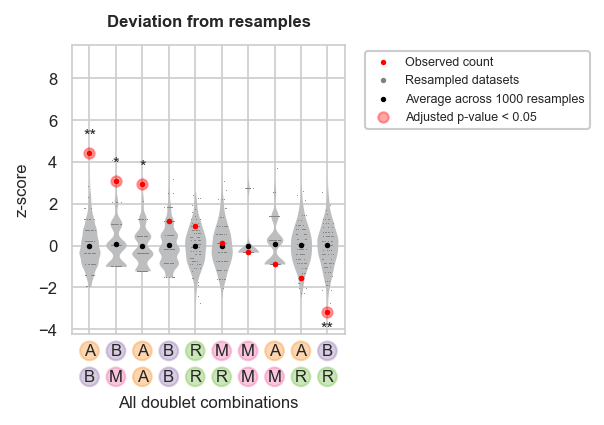

In [38]:
plot_deviation('doublet', 
                    df_true_melt_subset, 
                    df_null_zscores_i_c_melt_subset, 
                    df_null_zscores_i_c_melt_100resamples_subset, 
                    cell_color_dict,
                    fdr_type='fdr_tsbh',
                    cutoff=None, 
                    title='auto',
                    multiple_datasets=False,
                    num_null=1000,
                    legend_bool=True,
                    legend_pos='outside',
                    save=False, 
                    image_format='png',
                    dpi=300,
                    image_save_path=None)

A similar analysis can be done for triplet and quartet motifs, as shown below.

## Triplet motif analysis

In [39]:
(triplet_dict, 
 cell_fates, 
 dfs_c) = resample.resample_trees_triplets(all_trees_sorted, 
                                           num_resamples=10000, 
                                           replacement_bool=True, 
                                           cell_fates='auto'
                                           )

  0%|          | 0/10000 [00:00<?, ?it/s]

In [40]:
(df_true_melt_subset, 
 df_melt_subset, 
 df_melt_100resamples_subset, 
 df_null_zscores_i_c_melt_subset, 
 df_null_zscores_i_c_melt_100resamples_subset) = dfs_for_plotting(dfs_c, 
                                                                       10000, 
                                                                       triplet_dict, 
                                                                       cutoff=15, 
                                                                       num_null=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [41]:
df_true_melt_subset

,subtree_val,observed,expected,z-score,abs z-score,label,null min,null mean,null max,p_val,adj_p_val_fdr_bh,adj_p_val_fdr_tsbh,null z-score min,null z-score mean,null z-score max
11,11,6.0,1.317164,4.077478,4.077478,"(B,(A,B))",0.0,1.3274,7.0,0.002300,0.034497,0.032197,-1.158472,-0.011646,4.956438
8,8,1.0,0.263433,1.485575,1.485575,"(A,(M,R))",0.0,0.2539,4.0,0.224978,0.569943,0.531947,-0.505577,0.008272,5.476282
13,13,3.0,1.646455,1.067869,1.067869,"(B,(A,R))",0.0,1.6486,8.0,0.226877,0.569943,0.531947,-1.302891,-0.019407,5.025427
30,30,5.0,3.512437,0.816725,0.816725,"(R,(A,A))",0.0,3.5155,12.0,0.274073,0.569943,0.531947,-1.934576,0.016808,4.673233
15,15,1.0,0.439055,0.807332,0.807332,"(B,(B,M))",0.0,0.4518,5.0,0.361564,0.602606,0.562433,-0.665412,-0.012886,3.755560
39,39,63.0,59.711428,0.596265,0.596265,"(R,(R,R))",39.0,59.7093,80.0,0.303970,0.569943,0.531947,-3.029214,-0.006216,3.497728
14,14,0.0,0.439055,-0.654286,0.654286,"(B,(B,B))",0.0,0.4335,4.0,0.649035,0.649035,0.605766,-0.654333,0.000835,5.391044
6,6,0.0,0.526866,-0.734075,0.734075,"(A,(B,R))",0.0,0.5307,6.0,0.584942,0.626723,0.584942,-0.734132,-0.063172,3.417751
1,1,0.0,0.526866,-0.742495,0.742495,"(A,(A,B))",0.0,0.5341,5.0,0.580342,0.626723,0.584942,-0.742553,0.005498,4.824071
10,10,0.0,0.548818,-0.747560,0.747560,"(B,(A,A))",0.0,0.5587,5.0,0.573643,0.626723,0.584942,-0.747618,0.016529,5.953432


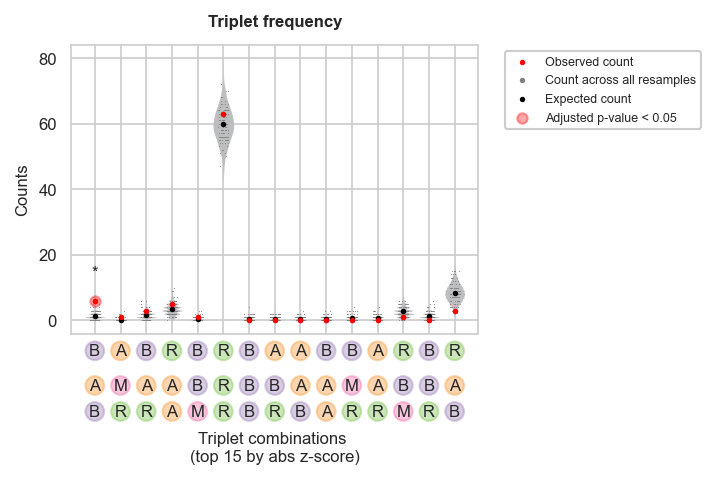

In [42]:
plot_frequency('triplet', 
                    df_true_melt_subset, 
                    df_melt_subset, 
                    df_melt_100resamples_subset, 
                    cell_color_dict,
                    fdr_type='fdr_tsbh',
                    cutoff=15, 
                    title='auto',
                    multiple_datasets=False,
                    legend_bool=True, 
                    legend_pos='outside',
                    save=False, 
                    image_format='png',
                    dpi=300,
                    image_save_path=None)

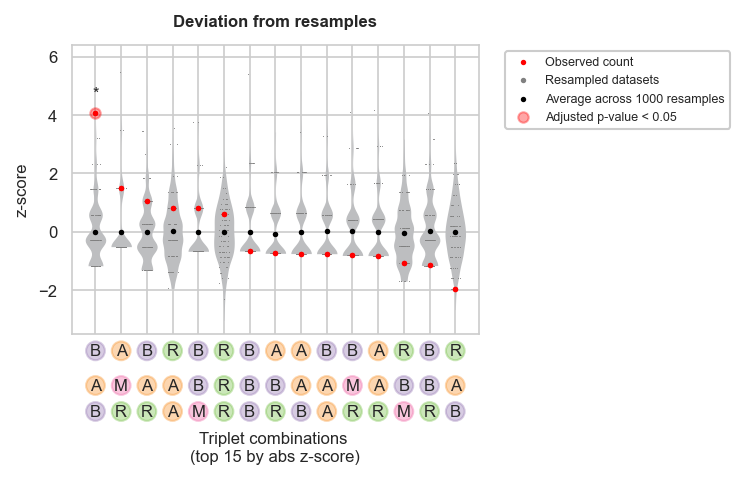

In [43]:
plot_deviation('triplet', 
                    df_true_melt_subset, 
                    df_null_zscores_i_c_melt_subset, 
                    df_null_zscores_i_c_melt_100resamples_subset, 
                    cell_color_dict,
                    fdr_type='fdr_tsbh',
                    cutoff=15, 
                    title='auto',
                    multiple_datasets=False,
                    num_null=1000,
                    legend_bool=True,
                    legend_pos='outside',
                    save=False, 
                    image_format='png',
                    dpi=300,
                    image_save_path=None)

## Quartet motif analysis

In [39]:
(quartet_dict, 
 cell_fates, 
 dfs_c) = resample.resample_trees_quartets(all_trees_sorted, 
                                           num_resamples=10000, 
                                           replacement_bool=True, 
                                           cell_fates='auto'
                                           )

  0%|          | 0/10000 [00:00<?, ?it/s]

In [41]:
(df_true_melt_subset, 
 df_melt_subset, 
 df_melt_100resamples_subset, 
 df_null_zscores_i_c_melt_subset, 
 df_null_zscores_i_c_melt_100resamples_subset) = plot.dfs_for_plotting(dfs_c, 
                                                                       10000, 
                                                                       quartet_dict, 
                                                                       cutoff=15, 
                                                                       num_null=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

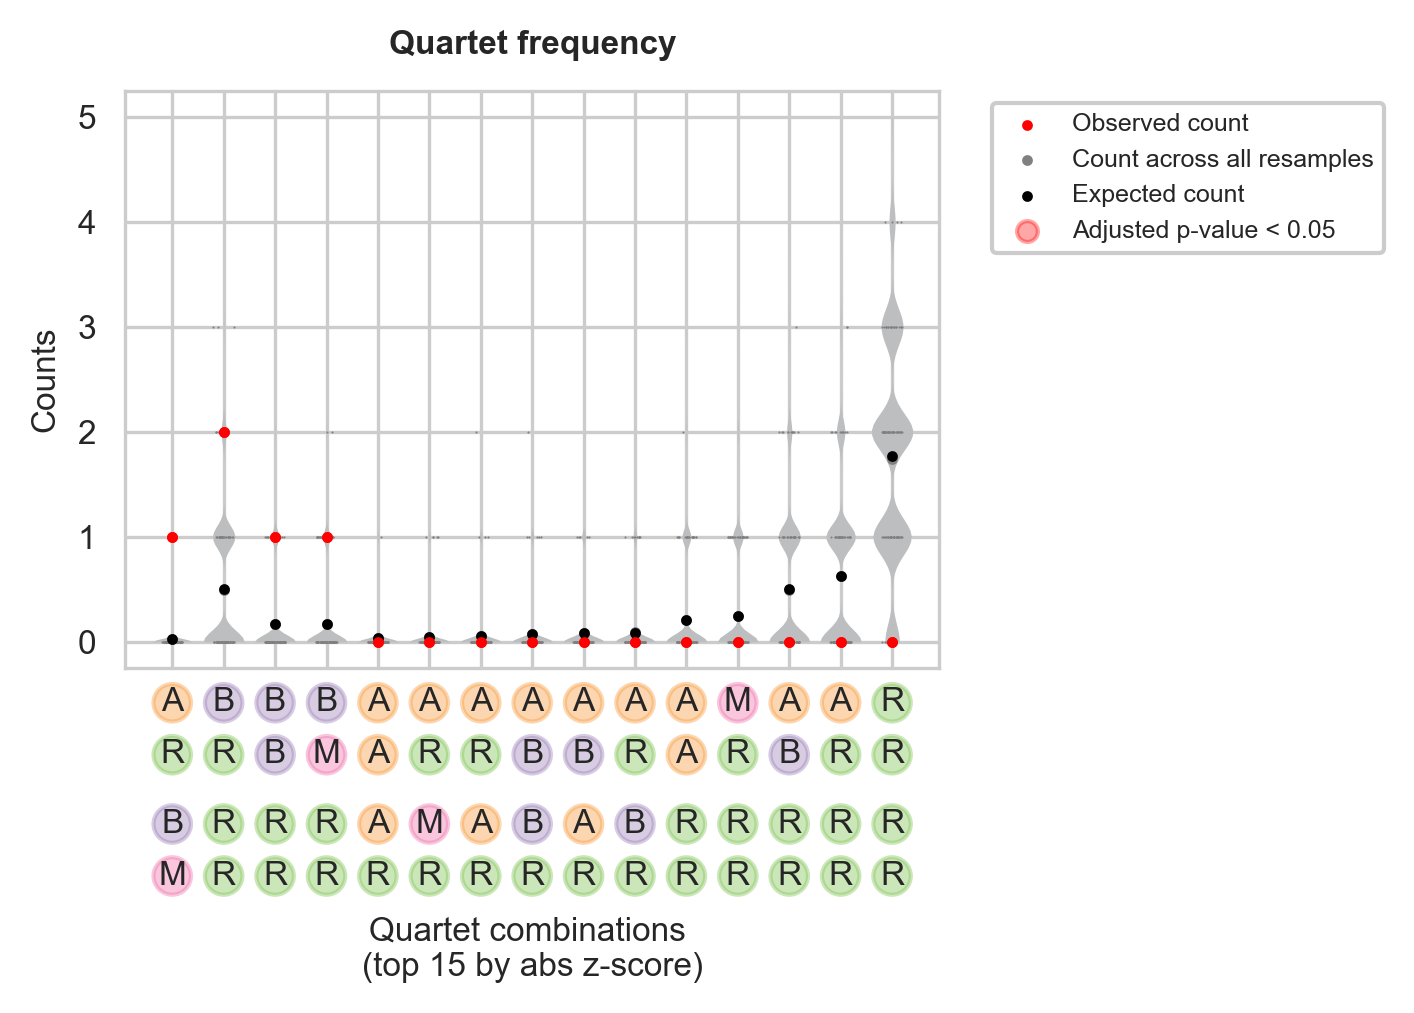

In [43]:
plot.plot_frequency('quartet', 
                    df_true_melt_subset, 
                    df_melt_subset, 
                    df_melt_100resamples_subset, 
                    cell_color_dict,
                    cutoff=15, 
                    title='auto',
                    multiple_datasets=False,
                    legend_bool=True, 
                    legend_pos='outside',
                    save=False, 
                    image_format='png',
                    dpi=300,
                    image_save_path=None)

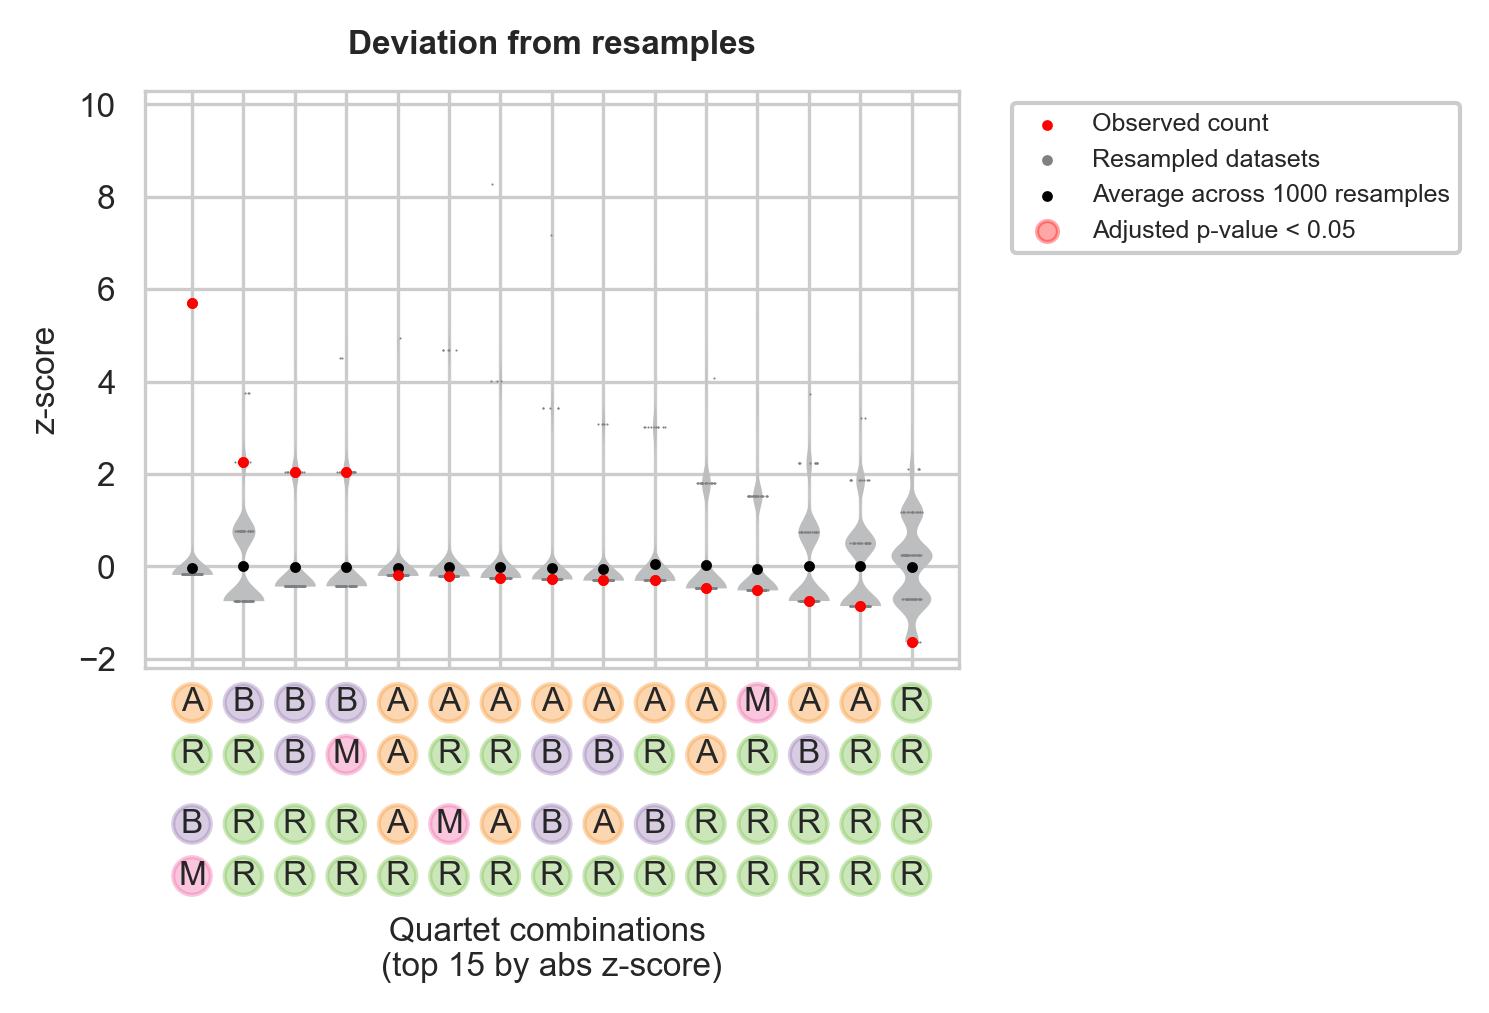

In [44]:
plot.plot_deviation('quartet', 
                    df_true_melt_subset, 
                    df_null_zscores_i_c_melt_subset, 
                    df_null_zscores_i_c_melt_100resamples_subset, 
                    cell_color_dict,
                    cutoff=15, 
                    title='auto',
                    multiple_datasets=False,
                    num_null=1000,
                    legend_bool=True,
                    legend_pos='outside',
                    save=False, 
                    image_format='png',
                    dpi=300,
                    image_save_path=None)